In [60]:
using PyPlot, DataFrames, Combinatorics, Statistics, CSV

In [10]:
include("../src/SparseKMeans.jl")
include("../src/RobustKMeans.jl")
include("../src/DataGeneration.jl");

Academic license - for non-commercial use only


In [3]:
function get_selected_features_from_weights(feature_weights::Array{Float64, 1}, p)
    d = size(feature_weights, 1)
    selected_features = Int64[]
    for j=1:p
        push!(
            selected_features,
            argmax(feature_weights .* [!(j in selected_features) for j=1:d])
        )
    end
    return selected_features
end

get_selected_features_from_weights (generic function with 1 method)

In [4]:
function calculate_feature_tpr(
    true_features::Array{Int64, 1}, 
    selected_features::Array{Int64, 1},
    p::Int64
)::Float64
    return sum([j in true_features for j in selected_features])/p
end

calculate_feature_tpr (generic function with 1 method)

In [5]:
function calculate_assignment_accuracy(
    true_assignments::Array{Int64, 1}, 
    cluster_assignments::Array{Int64, 1},
    K::Int64    
)::Float64
     best_score = 0
    for perm in permutations(1:K)
        perm_score = 0
        for k=1:K
            perm_score += sum((true_assignments .== k) .* (cluster_assignments .== perm[k]))
        end
        if perm_score > best_score
            best_score = perm_score
        end
    end
    return best_score / size(true_assignments, 1)
end

calculate_assignment_accuracy (generic function with 1 method)

In [99]:
n = 100
p = 20
K = 3
num_trials = 20
σ_noise = 1.0
SNR_grid = [1.1, 1.5, 2, 5]
d_grid = [100, 500, 1000, 5000, 10000]
sparse_kmeans_results = []
robust_kmeans_results = []
for SNR in SNR_grid
    for d in d_grid
        for trial=1:num_trials
            σ_group = SNR * σ_noise
            X, true_assignments, true_features = generate_random_data(n, d, p, K, σ_noise=σ_noise, σ_group=σ_group,
            seed=trial)
            selected_features, sparse_cluster_assignments = sparse_kmeans(X, K, p, num_restarts_per_solve=30)
            feature_weights, robust_cluster_assignments = robust_kmeans(X, K, λ=sqrt(p))
            push!(
                sparse_kmeans_results,
                Dict(
                    :trial => trial,
                    :n => n,
                    :d => d,
                    :p => p,
                    :K => K,
                    :SNR => SNR,
                    :feature_tpr => calculate_feature_tpr(true_features, selected_features, p),
                    :cluster_accuracy => calculate_assignment_accuracy(true_assignments, sparse_cluster_assignments, 
                        K),
                    :selected_feature_count => p
                )
            )
            push!(
                robust_kmeans_results,
                Dict(
                    :trial => trial,
                    :n => n,
                    :d => d,
                    :p => p,
                    :K => K,
                    :SNR => SNR,
                    :feature_tpr => calculate_feature_tpr(true_features, get_selected_features_from_weights(
                            feature_weights, p), p),
                    :cluster_accuracy => calculate_assignment_accuracy(true_assignments, robust_cluster_assignments, 
                        K),
                    :selected_feature_count => sum(feature_weights .> 1e-4)
                )
            )
        end
        println("Completed iteration with d=$d and SNR=$SNR.")
    end
end

Completed iteration with d=100 and SNR=1.1.
Completed iteration with d=500 and SNR=1.1.
Completed iteration with d=1000 and SNR=1.1.
Completed iteration with d=5000 and SNR=1.1.
Completed iteration with d=10000 and SNR=1.1.
Completed iteration with d=100 and SNR=1.5.
Completed iteration with d=500 and SNR=1.5.
Completed iteration with d=1000 and SNR=1.5.
Completed iteration with d=5000 and SNR=1.5.
Completed iteration with d=10000 and SNR=1.5.
Completed iteration with d=100 and SNR=2.0.
Completed iteration with d=500 and SNR=2.0.
Completed iteration with d=1000 and SNR=2.0.
Completed iteration with d=5000 and SNR=2.0.
Completed iteration with d=10000 and SNR=2.0.
Completed iteration with d=100 and SNR=5.0.
Completed iteration with d=500 and SNR=5.0.
Completed iteration with d=1000 and SNR=5.0.
Completed iteration with d=5000 and SNR=5.0.
Completed iteration with d=10000 and SNR=5.0.


In [100]:
function aggregate_results(results)
    df = DataFrame(
        Dict(
            key => [result[key] for result in results]
            for key in keys(results[1])
        )
    )
    return aggregate(groupby(df, [:n, :d, :p, :K, :SNR]), [mean, std])
end

aggregate_results (generic function with 1 method)

In [101]:
sparse_df = aggregate_results(sparse_kmeans_results)
robust_df = aggregate_results(robust_kmeans_results);

In [102]:
CSV.write("sparse_results_2.csv", sparse_df)

"sparse_results_2.csv"

In [103]:
CSV.write("robust_results_2.csv", robust_df)

"robust_results_2.csv"

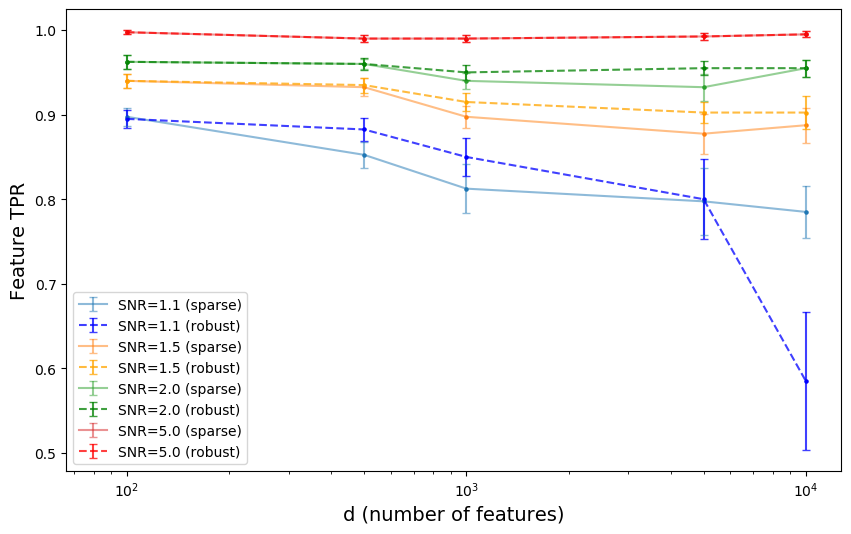

PyObject <matplotlib.legend.Legend object at 0x14db1aef0>

In [168]:
sparse_color = ["tab:blue", "tab:orange", "tab:green", "tab:red"]
robust_color = ["blue", "orange", "green", "red"]
plt.figure(figsize=(10,6))
for (i, SNR) in enumerate(SNR_grid)
    plt.errorbar(
        d_grid, 
        sparse_df[sparse_df[:,:SNR] .== SNR, :feature_tpr_mean], 
        sparse_df[sparse_df[:,:SNR] .== SNR, :feature_tpr_std]/sqrt(num_trials),
        color=sparse_color[i], label="SNR=$SNR (sparse)", alpha=0.5, capsize=3)
    plt.scatter(d_grid, sparse_df[sparse_df[:,:SNR] .== SNR, :feature_tpr_mean], color=sparse_color[i], s=5)
    plt.errorbar(
        d_grid, 
        robust_df[robust_df[:,:SNR] .== SNR, :feature_tpr_mean], 
        robust_df[robust_df[:,:SNR] .== SNR, :feature_tpr_std]/sqrt(num_trials),
        linestyle="--", color=robust_color[i], label="SNR=$SNR (robust)", alpha=0.75, capsize=3)
    plt.scatter(d_grid, robust_df[robust_df[:,:SNR] .== SNR, :feature_tpr_mean], color=robust_color[i], s=5)
end
plt.xlabel("d (number of features)", fontsize=14)
plt.ylabel("Feature TPR", fontsize=14)
plt.xscale("log")
plt.legend()

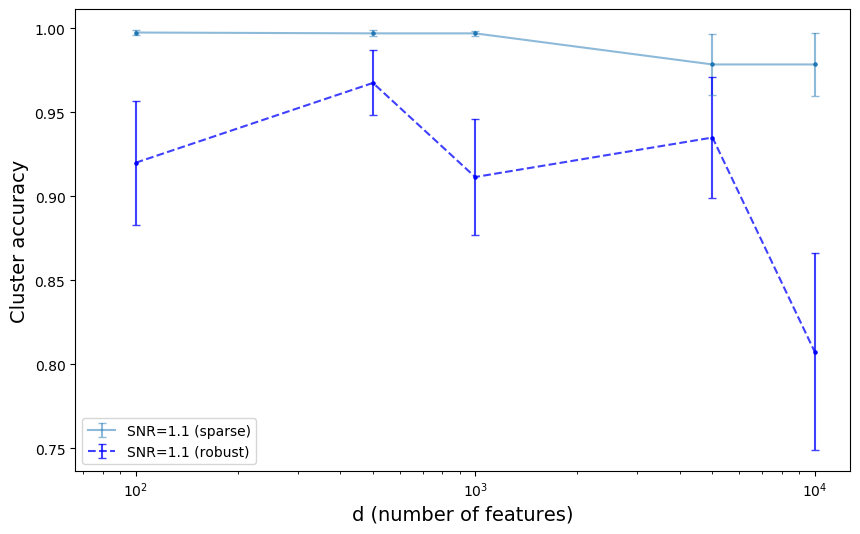

PyObject <matplotlib.legend.Legend object at 0x14f711940>

In [162]:
sparse_color = ["tab:blue", "tab:orange", "tab:green", "tab:red"]
robust_color = ["blue", "orange", "green", "red"]
plt.figure(figsize=(10,6))
for (i, SNR) in enumerate(SNR_grid[1])
    plt.errorbar(
        d_grid, 
        sparse_df[sparse_df[:,:SNR] .== SNR, :cluster_accuracy_mean], 
        sparse_df[sparse_df[:,:SNR] .== SNR, :cluster_accuracy_std]/sqrt(num_trials),
        color=sparse_color[i], label="SNR=$SNR (sparse)", alpha=0.5, capsize=3)
    plt.scatter(d_grid, sparse_df[sparse_df[:,:SNR] .== SNR, :cluster_accuracy_mean], color=sparse_color[i], s=5)
    plt.errorbar(
        d_grid, 
        robust_df[robust_df[:,:SNR] .== SNR, :cluster_accuracy_mean], 
        robust_df[robust_df[:,:SNR] .== SNR, :cluster_accuracy_std]/sqrt(num_trials),
        linestyle="--", color=robust_color[i], label="SNR=$SNR (robust)", alpha=0.75, capsize=3)
    plt.scatter(d_grid, robust_df[robust_df[:,:SNR] .== SNR, :cluster_accuracy_mean], color=robust_color[i], s=5)
end
plt.xlabel("d (number of features)", fontsize=14)
plt.ylabel("Cluster accuracy", fontsize=14)
plt.xscale("log")
plt.legend()

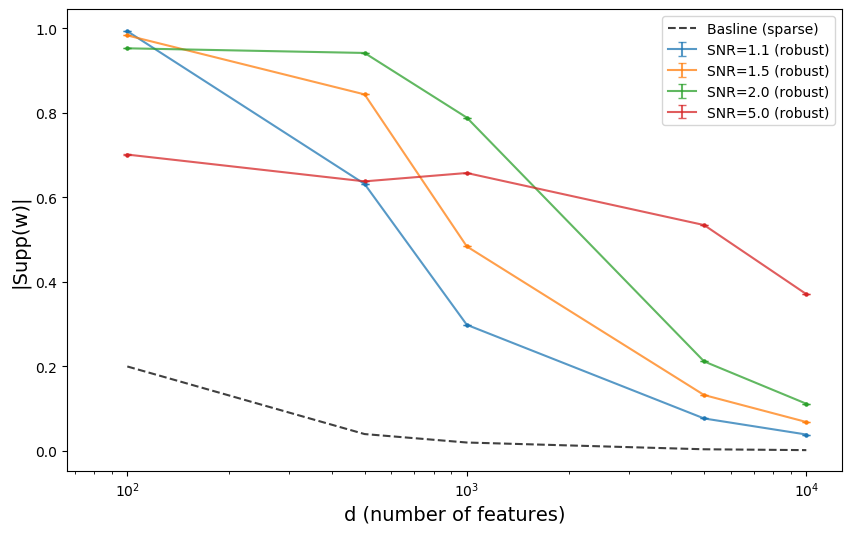

PyObject <matplotlib.legend.Legend object at 0x14dc69390>

In [177]:
robust_color = ["tab:blue", "tab:orange", "tab:green", "tab:red"]
plt.figure(figsize=(10,6))
for (i, SNR) in enumerate(SNR_grid)
    plt.errorbar(
        d_grid, 
        robust_df[robust_df[:,:SNR] .== SNR, :selected_feature_count_mean] ./ d_grid, 
        robust_df[robust_df[:,:SNR] .== SNR, :selected_feature_count_std]/sqrt(num_trials) ./ (d_grid.^2),
        color=robust_color[i], label="SNR=$SNR (robust)", alpha=0.75, capsize=3)
    plt.scatter(d_grid, robust_df[robust_df[:,:SNR] .== SNR, :selected_feature_count_mean] ./ d_grid, 
        color=robust_color[i], s=5)
end
plt.plot(d_grid, 20 ./ d_grid, c="k", linestyle="--", alpha=0.75, label="Basline (sparse)")
plt.xlabel("d (number of features)", fontsize=14)
plt.ylabel("|Supp(w)|", fontsize=14)
plt.xscale("log")
plt.legend()

In [165]:
sparse_df

,n,d,p,K,SNR,cluster_accuracy_mean,feature_tpr_mean,selected_feature_count_mean
,Int64,Int64,Int64,Int64,Float64,Float64,Float64,Float64
1,100,100,20,3,1.1,0.9975,0.8975,20.0
2,100,500,20,3,1.1,0.997,0.8525,20.0
3,100,1000,20,3,1.1,0.997,0.8125,20.0
4,100,5000,20,3,1.1,0.9785,0.7975,20.0
5,100,10000,20,3,1.1,0.9785,0.785,20.0
6,100,100,20,3,1.5,1.0,0.94,20.0
7,100,500,20,3,1.5,1.0,0.9325,20.0
8,100,1000,20,3,1.5,1.0,0.8975,20.0
9,100,5000,20,3,1.5,0.981,0.8775,20.0
